# Hello, PyTorch! -- MNIST Handwritten Digits

- https://en.wikipedia.org/wiki/MNIST_database

# Load Datasets

In [2]:
import torch
from torchvision import datasets, transforms

In [3]:
x = datasets.MNIST('data', download = True)
x[0]

(<PIL.Image.Image image mode=L size=28x28>, 5)

In [4]:
x[0][0]

In [5]:
transform=transforms.Compose([
    transforms.ToTensor(),  #Changes an image or array into a PyTorch tensor and scales the pixel values to be between 0 and 1
    transforms.Normalize((0.1307,), (0.3081,)) #Normalizes the tensor by subtracting by a mean and dividing by a standard deviation
    ])

In [6]:
#Access the predefined PyTorch dataset of handwritten digits
#There are 60,000 images in this training set
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)

#Specify the batch size 
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64) 

#Load the test set of 10,000 images 
dataset2 = datasets.MNIST('data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=1000)

In [7]:
#Retrieve the first batch of data, will return an index (i) and batch data (x)
i, x = next(enumerate(train_loader))
x[0].shape

torch.Size([64, 1, 28, 28])

# View Image

In [21]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

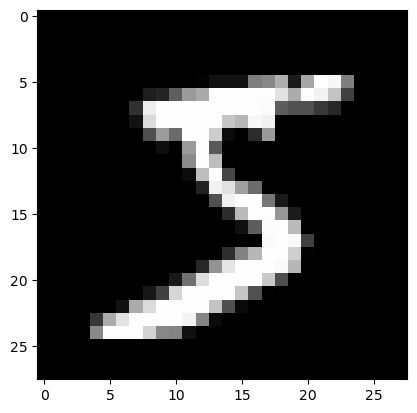

In [9]:
#Retrieve the first batch
i, x = next(enumerate(train_loader))

#Select the first image in the batch and remove singleton dimensions 
x2 = np.squeeze(x[0][0])

#Display the image stored in x2
plt.imshow(x2, cmap='gray')

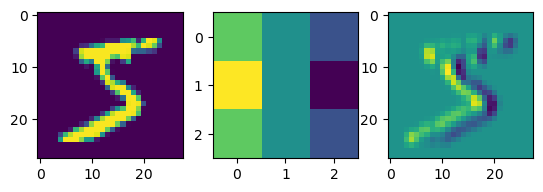

In [10]:
#Define a Sobel kernel for horizontal edge detection
kernel = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])

#Apply the kernel to the image using convolution
# y will be the image with highlighted edges 
y = scipy.ndimage.convolve(x2, kernel)

#Display three images side by side (original, kernel/edge detection filter, output of convolution)
fig, axes = plt.subplots(1,3)
axes[0].imshow(x2)
axes[1].imshow(kernel)
axes[2].imshow(y)

# Create Network

In [22]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary

In [12]:
#Define a convolutional neural network called Net
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #define first convolutional layer, take 1 channel image and output 10 feature maps
        #kernel size is 5 x 5 region
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        #define second convolutional layer, take 1 channel image and output 20 feature maps
        #kernel size is 5 x 5 region
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        #randomly set some values to 0 to prevent overfitting
        self.conv2_drop = nn.Dropout2d()
        #take flattened output of previous layers and map to 50 neurons
        self.fc1 = nn.Linear(320, 50)
        #take 50 outputs from the previous layer and map to 10 output neurons (digits 0 to 9)
        self.fc2 = nn.Linear(50, 10)

    #This is a bit more complex and confusing
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [23]:
network = Net()
#Create an optimizer for training the network
#Learning rate is 0.01, take small steps to update weights
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
summary(network, input_size=(1,28,28))

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_22225/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Conv2d: 1-1                            [10, 24, 24]              260
├─Conv2d: 1-2                            [20, 8, 8]                5,020
├─Dropout2d: 1-3                         [20, 8, 8]                --
├─Linear: 1-4                            [1, 50]                   16,050
├─Linear: 1-5                            [1, 10]                   510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.88
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.09
Estimated Total Size (MB): 0.15

# Visualize Weights

In [24]:
#Display the 10 filters of the first convolutional layer and the result of applying the filters to the image
def visualize():
    i, x = next(enumerate(test_loader))
    x2 = np.squeeze(x[0][0])
    weights = network.conv1.weight.data
    
    fig, axes = plt.subplots(10,2)
    for i in range(10):
        weights_np = np.squeeze(weights.numpy()[i,0,:,:])
        axes[i,0].imshow(weights_np)
        axes[i,1].imshow(scipy.ndimage.convolve(x2, weights_np))

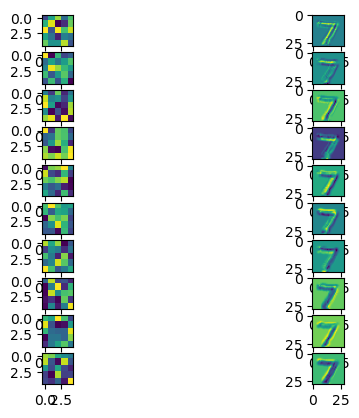

In [15]:
visualize()

# Predict Using Network

In [25]:
#Return the labels for the first five images of the current batch
i, x = next(enumerate(train_loader))
x[1][:5]

tensor([5, 0, 4, 1, 9])

In [17]:
#Returns the predictions for the first five images of the current batch
y = network(x[0])
pred = y.data.max(1)[1]
pred[:5]

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_22225/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


tensor([3, 9, 3, 3, 4])

# First Test and Train

In [27]:
#Calculate the accuracy of the network
def test():
  network.eval()
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  print('Test accuracy: {:.0f}%\n'.format(100. * correct / len(test_loader.dataset)))

In [28]:
test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_22225/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Test accuracy: 13%



In [20]:
#Train the neural network on the training set
#and continuously compute the loss and update the model to minimize loss 
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
def train():
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 100 == 0:
      print('Train loss: {:.6f}'.format(loss.item()))

In [29]:
train()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_22225/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.316056
Train loss: 1.887413
Train loss: 0.920161
Train loss: 1.001261
Train loss: 0.753420
Train loss: 0.543244
Train loss: 0.530782
Train loss: 0.702304
Train loss: 0.516423
Train loss: 0.622314


# Train Network

In [24]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_6776/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.328357
Train loss: 2.202135
Train loss: 1.352435
Train loss: 0.801246
Train loss: 0.513766
Train loss: 0.680657
Train loss: 0.526784
Train loss: 0.583293
Train loss: 0.627161
Train loss: 0.466526
Test accuracy: 94%

Train loss: 0.470476
Train loss: 0.257642
Train loss: 0.308270
Train loss: 0.477088
Train loss: 0.455900
Train loss: 0.407844
Train loss: 0.322788
Train loss: 0.416832
Train loss: 0.350391
Train loss: 0.307870
Test accuracy: 96%

Train loss: 0.225584
Train loss: 0.264213
Train loss: 0.353725
Train loss: 0.415473
Train loss: 0.181282
Train loss: 0.445911
Train loss: 0.160532
Train loss: 0.344255
Train loss: 0.538999
Train loss: 0.239903
Test accuracy: 97%

Train loss: 0.184747
Train loss: 0.218457
Train loss: 0.166741
Train loss: 0.355436
Train loss: 0.075430
Train loss: 0.208353
Train loss: 0.133621
Train loss: 0.363893
Train loss: 0.236777
Train loss: 0.241382
Test accuracy: 97%

Train loss: 0.190274
Train loss: 0.157133
Train loss: 0.253864
Train loss: 0.293

# Inspect Network

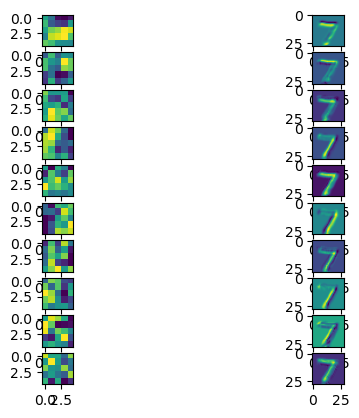

In [30]:
visualize()

In [31]:
i, x = next(enumerate(train_loader))
x[1][:5]

tensor([5, 0, 4, 1, 9])

In [32]:
y = network(x[0])
pred = y.data.max(1)[1]
pred[:5]

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_22225/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


tensor([3, 0, 4, 1, 9])

# How Much Data?

- What is the accuracy using 60,000 images? 30,000? 6,000? 3,000? 600?
- How do the weights looks different when trained with 60,000 vs 600?

In [42]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(60000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [43]:
# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_22225/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.334838
Train loss: 1.933855
Train loss: 1.019908
Train loss: 0.890829
Train loss: 0.712389
Train loss: 0.589290
Train loss: 0.463852
Train loss: 0.651708
Train loss: 0.427723
Train loss: 0.581312
Test accuracy: 94%

Train loss: 0.376237
Train loss: 0.341307
Train loss: 0.336676
Train loss: 0.412215
Train loss: 0.435884
Train loss: 0.439174
Train loss: 0.415948
Train loss: 0.310436
Train loss: 0.472559
Train loss: 0.314046
Test accuracy: 96%

Train loss: 0.276878
Train loss: 0.215509
Train loss: 0.235999
Train loss: 0.570142
Train loss: 0.257249
Train loss: 0.235601
Train loss: 0.262892
Train loss: 0.435340
Train loss: 0.424933
Train loss: 0.277642
Test accuracy: 97%

Train loss: 0.212974
Train loss: 0.100228
Train loss: 0.189605
Train loss: 0.219883
Train loss: 0.192566
Train loss: 0.261831
Train loss: 0.209001
Train loss: 0.345608
Train loss: 0.477754
Train loss: 0.221944
Test accuracy: 98%

Train loss: 0.106233
Train loss: 0.232880
Train loss: 0.146040
Train loss: 0.230

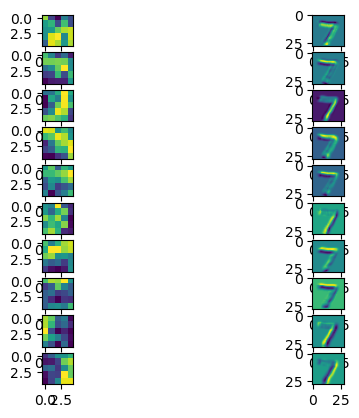

In [44]:
visualize()

In [ ]:
#30000 images
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(30000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [ ]:
# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

In [ ]:
#6000 images
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(6000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [ ]:
# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

In [ ]:
#3000 images
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(3000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [ ]:
# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

In [ ]:
#600 images
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(600))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [ ]:
# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

In [ ]:
#600 images
visualize()

In [ ]:
#Question 1a.
#With 60,000 images, the accuracy is 98%
#With 30,000 images, the accuracy is 97%
#With 6,000 images, the accuracy is 92%
#With 3,000 images, the accuracy is 85%
#With 600 images, the accuracy is 36%


In [ ]:
#Question 1b.
#The heatmaps for the kernels look more ordered in the 60,000 image set, like there is a more defined pattern